## Local Search Algorithms - Hill Climbing and Simulated Annealing
### Solving n equations with m unknowns (m > n)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from math import exp, log
import random

### `class Answer`
Keeps a answer vector and its MSE value.

In [1]:
class Answer:

    def __init__(self, vector=None, MSE=float('inf')):
        self.vector = vector
        self.MSE = MSE
    
    def __lt__(self, other):
        return self.MSE < other.MSE
  
    def __repr__(self):
        return f'MSE: {self.MSE}\nanswer vector:\n{self.vector}'

### `class AnswerProgress`
Responsible for keeping the status of the answer during the execution of the algorithm, and finally drawing the data as a graph.

In [3]:
class AnswerProgress:

    def __init__(self, *parameters):
        self.data = {parameter:[] for parameter in parameters}
  
    def add_row(self, row):
        for parameter in self.data:
          self.data[parameter].append(row[parameter])

    def plot(self, x, y, invert=False, ylim = None):
        plt.close()
        plt.figure(figsize=(15, 10))
        if invert:
            plt.axes().set_xlim(max(self.data[x]), min(self.data[x]))
        
        if ylim:
            plt.ylim(ylim)
        
        plt.xlabel(x)
        plt.ylabel(y)
        plt.plot(self.data[x], self.data[y])
        plt.show()

<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        کلاس <code>EquationSystem</code>، نگهدارنده‌ی اطلاعات یک دستگاه معادلات است.
        <br>
        این اطلاعات شامل ماتریس ضرایب 
        (<code>coefficient_matrix</code>)، 
        بردار سمت راست معادله 
        (<code>rhs_vector</code>)،
        کاندیدای حال حاضر جواب
        (<code>current_soloution</code>)
        و بهترین کاندید جواب تا به حال
        (<code>best_soloution</code>)
        می باشد.
        <br>
        این کلاس همچنین چند عملیات انجام می‌دهد که عبارت اند از:
        <br>
        تابع
        <code>read_from_csv</code>:
        این تابع یک فایل حاوی ماتریس ضرایب و بردار سمت راست معادله را می‌خواند و اطلاعات آن را در همان $object$
        ذخیره می‌کند.
        <br>
        تابع
        <code>generate_random_soloution_vector</code>:
        این تابع یک بردار جواب تصادفی تولید کرده و برمی‌گرداند.
        <br>
        تابع
        <code>calculate_rhs_vector</code>:
        این تابع یک بردار جواب را به‌عنوان ورودی می‌گیرد و بردار سمت راست معادله را به ازای آن جواب برمی‌گرداند.
        <br>
        تابع
        <code>calculate_MSE</code>:
        این تابع یک بردار جواب به عنوان ورودی می‌گیرد و مقدار $MSE$
        آن را محاسبه می‌کند. $MSE$
        نیز اینجا درواقع $Mean \space Squared \space Error$
        مقدار سمت راست واقعی نسبت به مقدار سمت راست بدست آمده از ورودی می‌باشد.
        <br>
        تابع
        <code>random_initialize</code>:
        این تابع مقدار یک مقدار تصادفی را بعنوان بردار جواب در نظر می‌گیرد.
        <br>
        تابع
        <code>generate_neighbour</code>:
        این تابع به ازای مقدار تغییر
        <code>change</code>
        در محل
        <index>
        یک همسایه از جواب فعلی می‌سازد و برمی‌گرداند.
    </font>
</div>

In [4]:
class EquationSystem:

    def __init__(self):
        self.coefficients_matrix = None
        self.rhs_vector = None
        self.current_soloution = Soloution()
        self.best_soloution = Soloution()
        self.n = 0
  
    def read_from_csv(self, path):
        equation_table = pd.read_csv(path, header=None)

        self.n = len(equation_table.columns) - 1
        print(f"n = {self.n}")

        self.coefficients_matrix = equation_table.drop([self.n], axis=1).values
        self.rhs_vector = equation_table[[self.n]].values

        return equation_table

    def generate_random_soloution_vector(self, min_range, max_range):
        return np.array([np.random.uniform(min_range, max_range, self.n)]).T
  
    def calculate_rhs_vector(self, soloution_vector):
        return np.dot(self.coefficients_matrix, soloution_vector)
  
    def calculate_MSE(self, soloution_vector):
        return ((self.rhs_vector - self.calculate_rhs_vector(soloution_vector))**2).mean(axis=0)[0]
  
    def reset(self):
        self.best_soloution = Soloution()
    
    def random_initialize(self, min_range, max_range):
        vector = self.generate_random_soloution_vector(min_range, max_range)
        self.current_soloution = Soloution(vector, self.calculate_MSE(vector))
  
    def set_soloution(self, soloution):
        self.current_soloution = soloution
        self.best_soloution = min(self.current_soloution, self.best_soloution)
  
    def generate_neighbour(self, index, change):
        neighbour = np.copy(self.current_soloution.vector)
        neighbour[index][0] += change
        return Soloution(neighbour, self.calculate_MSE(neighbour))

<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        کلاس
        <code>HillClimbing</code>:
        این کلاس الگوریتم $Hill \space Climbing$
        را برای معادله داده شده
        (<code>equation_system</code>)،
        و با تولید حالت اولیه در بازه‌ی داده‌شده اجرا می‌کند
        <br>
        الگوریتم با فراخوانی تابع
        <code>search</code>
        اجرا شده و پاسخ نهایی را خروجی می‌دهد.
        <br>
        نحوه‌ی اجرای الگوریتم به این صورت است که ابتدا یک حالت اولیه تصادفی می‌سازد. سپس تا زمانی که حداقل یکی از همسایه‌های حالت فعلی، $MSE$
        کمتری نسبت به حالت فعلی داشته باشد(حالت فعلی یک مینیمم محلی نباشد)، بهترین همسایه را بعنوان حالت بعدی انتخاب می‌کند.
        <br>
        اگر به یک مینیمم محلی رسید، گام خود را $\beta$
        برابر کرده و الگوریتم را تا زمانی که
        <code>step >= min_step</code>
        باشد، ادامه می‌دهد.
        <br>
        همچنین با یک بار اجرای تابع
        <code>search</code>،
        الگوریتم به تعداد
        <code>number_of_repeats</code>
        بار اجرا شده و بهترین حالت را خروجی می‌دهد.
        <br>
        این الگوریتم، در ابتدا بصورت گام ثابت اجرا شد و نتایج نشان می‌دادند که هم زمان اجرای الگوریتم در ازای دقت بیشتر بسیار زیاد می‌شود، و هم اینکه دقت آن در حدود $10^{-4}$
        بود. درحالی که الگوریتم فعلی، دقتی در حدود $10^{-23}$
        دارد.
        <br>
        همچنین مقادیر بهینه‌ی پارامترهای مسئله پس از آزمون و خطا بصورت زیر می‌باشند:
$$
Step_{start} = 1000, \space \beta = 0.1, \space Step_{min} = 10^{-12}
$$
        این الگوریتم، پارامترهای $level$
        به معنی مرحله‌ی اجرای الگوریتم و $MSE$
        آن مرحله را در
        <code>SoloutionProgress</code>
        ثبت می‌کند و پس از اجرای الگوریتم می‌توان نمودار آن را مشاهده کرد.
    </font>
</div>

In [5]:
class HillClimbing:

    def __init__(self, equation_system: EquationSystem, min_range, max_range, number_of_repeats=1, starting_step=1000, beta=0.1, min_step=1e-12):
        self.equation = equation_system
        self.starting_step = starting_step
        self.step = starting_step
        self.min_step = min_step
        self.min_range = min_range
        self.max_range = max_range
        self.level = 0
        self.progress = None
        self.number_of_repeats = number_of_repeats
        self.beta = beta

    def generate_neighbours(self):
        for index in range(self.equation.n):
            for change in [-self.step, self.step]:
                yield self.equation.generate_neighbour(index, change)   

    def get_best_neighbour(self):
        neighbours = list(self.generate_neighbours())
        return min(neighbours + [self.equation.current_soloution])

    def print_status(self):
        sys.stdout.write(f"""\rcurrent level: {self.level:6d} - current MSE: {self.equation.current_soloution.MSE:<10e} - step: {self.step:<10e}""")
        sys.stdout.flush()
    
    def reset(self):
        self.equation.random_initialize(self.min_range, self.max_range)
        self.step = self.starting_step

    def search(self):
        self.progress = SoloutionProgress('level', 'MSE')
        self.equation.reset()
        
        for _ in range(self.number_of_repeats):
            self.reset()

            while self.step >= self.min_step:
                best_neighbour = self.get_best_neighbour()

                if best_neighbour is self.equation.current_soloution:
                    self.step *= self.beta
                    continue

                self.equation.set_soloution(best_neighbour)
                self.progress.add_row({'level': self.level, 'MSE': self.equation.current_soloution.MSE})

                if self.level % 53 == 0:
                    self.print_status()
                self.level += 1

        self.print_status()
        print()
        return self.equation.best_soloution

<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        کلاس
        <code>SimulatedAnnealing</code>:
        این کلاس الگوریتم $Simulated \space Annealing$
        را برای معادله داده شده
        (<code>equation_system</code>)
        و با تولید حالت اولیه در بازه‌ی داده‌شده اجرا می‌کند
        <br>
        الگوریتم با فراخوانی تابع
        <code>search</code>
        اجرا شده و پاسخ نهایی را خروجی می‌دهد
        <br>
        پارامترهای الگوریتم عبارت اند از $T$
        به معنی دما در هرلحظه از اجرای الگوریتم، $T_{min}$
        به معنای کمترین مقدار دمای ممکن، که پایان‌دهنده‌ی الگوریتم است، $\alpha$
        که ضریبیست که در هر مرحله، در دما ضرب شده و مقدار آن را کاهش می‌دهد، $Step_{start}$
        که مقدار گام در شروع الگوریتم است و $\beta$
        که در هر بار برخورد به بمبست، در $Step$
        ضرب شده و مقدار آن را کاهش می‌دهد.
        <br>
        نحوه‌ی اجرای الگوریتم به این صورت است که ابتدا یک حالت اولیه‌ی تصادفی تولید می‌کند.
        سپس تا زمانی که
        <code>t > t_min</code>
        باشد به حالت بعد می‌رود.
        <br>
        نحوه‌ی تولید حالت بعد در مرحله‌ی $i$ ام
        ($C_i$)
        بصورت زیر است:
        <br>
        ابتدا تمام همسایه‌ها بُر زده می‌شوند. سپس به‌ترتیب، هنگام مشاهده‌ی همسایه‌ی $j$ ام
        ($N_j$)،
        اگر $MSE$
        کمتری از حالت فعلی داشت، با احتمال ۱ آن را بعنوان حالت بعد برمی‌گرداند. در غیر این صورت، با احتمال زیر، آن همسایه را بر می‌گرداند،
        و اگر آن را نیز برنگرداند، سراغ همسایه بعدی می‌رود.
        <br>
$$p = e^{\frac{MSE(C_i) - MSE(N_j)}{T_i}}$$
        اگر هیچکدام از همسایه‌ها برگزیده نشدند، مقدار $Step$
        در $\beta$
        ضرب شده و الگوریتم از سر گرفته می‌شود.
        <br>
        تاثیر پارامتر $T$
        بر الگوریتم:
        اگر این پارامتر با شیب زیادی کاهش یابد، الگوریتم خیلی سریع به $Hill \space Climbing$
        تبدیل می‌شود و در دام مینیمم‌های محلی می‌افتد.
        اگر مقدار اولیه‌ی آن بسیار بزرگ باشد، مقدار $p$
        تا مدت زیادی نزدیک به ۱ خواهد بود و می‌تواند روی اجرای الگوریتم تاثیر منفی بگذارد.
        <br>
        مقادر بهینه‌ی پارامتر های الگوریتم پس از انجام آزمون و خطا، عبارت اند از:
$$
Step_{start} = 1000, \space \beta = 0.1, \space T_0 = 1, \space \alpha = 0.999, \space T_{min} = 10^{-30}
$$
        که در نهایت از نظر زمانی تفاوت چندانی با یک بار اجرای $Hill \space Climbing$
        ندارد، اما دقت آن تا $10^{-28}$
        می‌تواند افزایش یابد.
        <br>
        برخلاف الگوریتم $Hill \space Climbing$
        که حالت نهایی الگوریتم، بهترین حالت مشاهده‌شده نیز هست، در این الگوریتم ممکن است بهترین حالت ممکن را قبل از پایان الگوریتم مشاهده کنیم.
        درنتیجه خروجی الگوریتم، حالت پایانی نیست، بلکه بهترین حالت مشاهده‌شده در طول اجرای الگوریتم است.
        <br>
        این الگوریتم، پارامترهای $level$
        به معنی مرحله‌ی اجرای الگوریتم، $MSE$
        آن مرحله و مقدار لگاریتم دمای آن مرحله را در
        <code>SoloutionProgress</code>
        ثبت می‌کند و پس از اجرای الگوریتم می‌توان نمودار آن را مشاهده کرد.
</font>
</div>

In [15]:
class SimulatedAnnealing:

    def __init__(self, equation_system: EquationSystem, min_range, max_range, starting_step = 1000, beta = 0.1, t_0=1, alpha=0.999, t_min=1e-30):
        self.equation = equation_system
        self.step = starting_step
        self.min_range = min_range
        self.max_range = max_range
        self.level = 0
        self.t = t_0
        self.t_min = t_min
        self.alpha = alpha
        self.beta = beta
        self.neighbour_changes = None
        self.progress = None
  
    def generate_all_neighbour_changes(self):
        for index in range(self.equation.n):
            for change in [-1, 1]:
                yield (index, change)

    def decision_probability(self, MSE):
        return exp((self.equation.current_soloution.MSE - MSE) / self.t)

    def decision(self, MSE):
        return np.random.uniform() < self.decision_probability(MSE)

    def generate_next_state(self):
        best_neighbour = self.equation.current_soloution

        random.shuffle(self.neighbour_changes)

        for change in self.neighbour_changes:
            neighbour = self.equation.generate_neighbour(change[0], change[1] * self.step)
            best_neighbour = min(best_neighbour, neighbour)

            if best_neighbour.MSE < self.equation.current_soloution.MSE:
                return best_neighbour

            if self.decision(neighbour.MSE):
                return neighbour
    
        return best_neighbour

    def print_status(self):
        sys.stdout.write(f"\rcurrent level: {self.level:6d} - current MSE: {self.equation.current_soloution.MSE:<10e} - T: {self.t:<10e} - step: {self.step:<10e}")
        sys.stdout.flush()
    
    def reset(self):
        self.progress = SoloutionProgress('level', 'MSE', 'log(T)')
        self.neighbour_changes = list(self.generate_all_neighbour_changes())
        self.equation.reset()
        self.equation.random_initialize(self.min_range, self.max_range)

    def search(self):
        self.reset()

        while self.t > self.t_min:
            next_state = self.generate_next_state()
            if next_state is self.equation.current_soloution:
                self.step *= self.beta
                continue
            
            self.equation.set_soloution(next_state)
            self.progress.add_row({'level': self.level, 'MSE': self.equation.current_soloution.MSE, 'log(T)': log(self.t)})
      
            if self.level % 53 == 0:
                self.print_status()
      
            self.level += 1
            self.t *= self.alpha
    
        self.print_status()
        print()
        return self.equation.best_soloution

<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        حال به سراغ اجرای الگوریتم‌ها می‌رویم.
        <br>
        ابتدا در تکه کد زیر، مقادیر پارامترهای بازه‌ی تولید حالت اولیه‌ی تصادفی را بعنوان ورودی وارد کنید.
    </font>
</div>

In [7]:
min_range = float(input("enter minimum of range: "))
max_range = float(input("enter maximum of range: "))

enter minimum of range: -1000
enter maximum of range: 1000


<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        دستگاه معادلات را از فایل می‌خوانیم:
    </font>
</div>

In [8]:
equation_system = EquationSystem()
equation_system.read_from_csv("new_example.csv")

n = 10


,0,1,2,3,4,5,6,7,8,9,10
0,0.2500,0.7500,0.0050,0.8870,0.2500,0.7800,0.3920,0.0050,0.4600,0.61,35.590
1,0.2300,0.0700,0.3500,0.7500,0.2000,0.6800,0.8900,0.1500,0.2700,0.64,49.250
2,0.5828,0.2091,0.4154,0.2140,0.6833,0.4514,0.0000,0.0000,0.6085,0.72,-0.720
3,0.7600,0.0590,-0.7889,-0.2600,0.6900,-0.0928,0.6300,-0.7200,0.2300,-0.17,93.225
4,0.5155,0.0000,0.0000,0.7833,0.8744,0.3200,0.8392,0.0272,0.0164,0.00,-54.900
5,0.5500,0.9100,0.9900,0.6400,0.0500,0.4930,0.9300,0.5800,0.6100,0.69,223.710
6,0.0100,0.0060,0.7313,0.5670,0.0580,0.5130,0.8200,0.0300,0.3527,0.41,-495.600


<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        یک شیء از کلاس
        <code>HillClimbing</code>
        می‌سازیم و پارامتهای ورودی را به آن پاس می‌دهیم. سپس الگوریتم را اجرا می‌کنیم.
        <br>
        در حین اجرای الگوریتم، مقادیر $level$، $MSE$
        و $Step$
        حال حاضر در خروجی نمایش داده می‌شود.
        در نهایت نیز بردار جواب چاپ می‌شود.
    </font>
</div>

In [9]:
hill_climbing = HillClimbing(equation_system, min_range, max_range, number_of_repeats=5)

In [10]:
hill_climbing.search()

current level:  30806 - current MSE: 3.491828e-24 - step: 1.000000e-13


MSE: 3.491828004715566e-24
soloution vector:
[[ 844.40023543]
 [-455.74352481]
 [-990.30522503]
 [-276.02117686]
 [-539.96659318]
 [ 576.96656713]
 [ -50.07958965]
 [1597.4254375 ]
 [ 738.62035344]
 [-372.26831139]]

<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        اختلاف بردار سمت راست معادله، در حالت واقعی مسئله با حالت بدست آمده از جواب الگوریتم نمایش داده شده است.
    </font>
</div>

In [11]:
equation_system.calculate_rhs_vector(equation_system.best_soloution.vector) - equation_system.rhs_vector

array([[ 7.88702437e-13],
       [-3.74456022e-12],
       [ 6.37490061e-13],
       [-1.03739239e-12],
       [ 1.43529633e-12],
       [-2.84217094e-14],
       [ 2.50111043e-12]])

<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        در نهایت نمودار $MSE$
        در بازه‌ی ۰ تا ۱
        بر حسب $level$
        رسم شده‌است:
    </font>
</div>

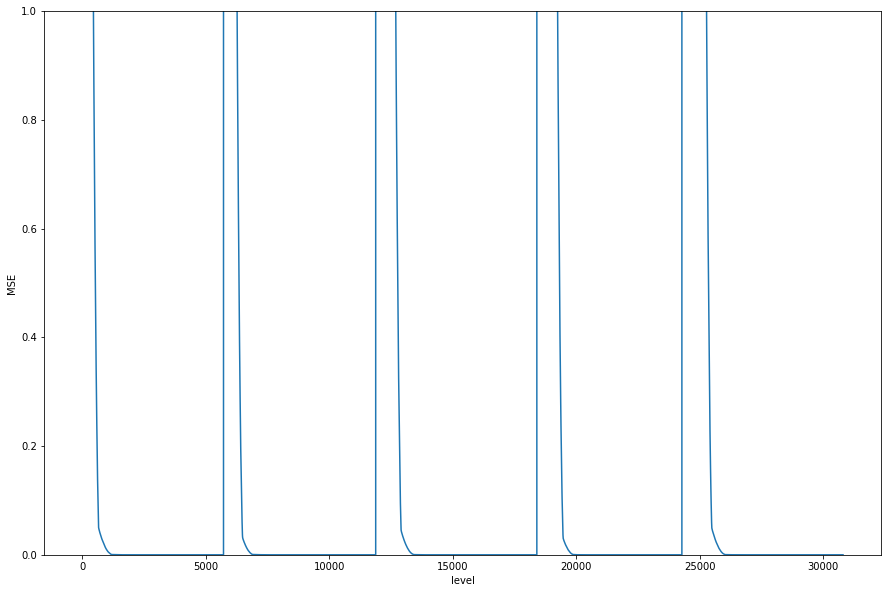

In [12]:
hill_climbing.progress.plot(x='level', y='MSE', ylim=(0, 1))

<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        یک شیء از کلاس
        <code>SimulatedAnnealing</code>
        می‌سازیم و پارامتهای ورودی را به آن پاس می‌دهیم. سپس الگوریتم را اجرا می‌کنیم.
        <br>
        در حین اجرای الگوریتم، مقادیر $level$، $MSE$،
        دما و گام حال حاضر در خروجی نمایش داده می‌شود.
        در نهایت نیز بردار جواب چاپ می‌شود.
    </font>
</div>

In [20]:
simulated_annealing = SimulatedAnnealing(equation_system, min_range, max_range)

In [21]:
simulated_annealing.search()

current level:  69044 - current MSE: 6.456263e-28 - T: 9.990082e-31 - step: 1.000000e-14


MSE: 6.456263037158824e-28
soloution vector:
[[ 685.64393608]
 [ 267.10318888]
 [-416.04305094]
 [-501.80150596]
 [-174.72643091]
 [ 333.52898607]
 [  34.56011556]
 [ 643.09004515]
 [-959.25073124]
 [ 523.03458164]]

<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        اختلاف بردار سمت راست معادله، در حالت واقعی مسئله با حالت بدست آمده از جواب الگوریتم نمایش داده شده است.
    </font>
</div>

In [22]:
equation_system.calculate_rhs_vector(equation_system.best_soloution.vector) - equation_system.rhs_vector

array([[ 2.13162821e-14],
       [-2.13162821e-14],
       [ 1.33226763e-14],
       [ 1.42108547e-14],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 5.68434189e-14]])

<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        در نهایت نمودار پارامترهای الگوریتم در طول اجرا رسم شده است.
        <br>
        نمودار $MSE$
        در بازه‌ی ۰ تا ۱
        برحسب $level$:
    </font>
</div>

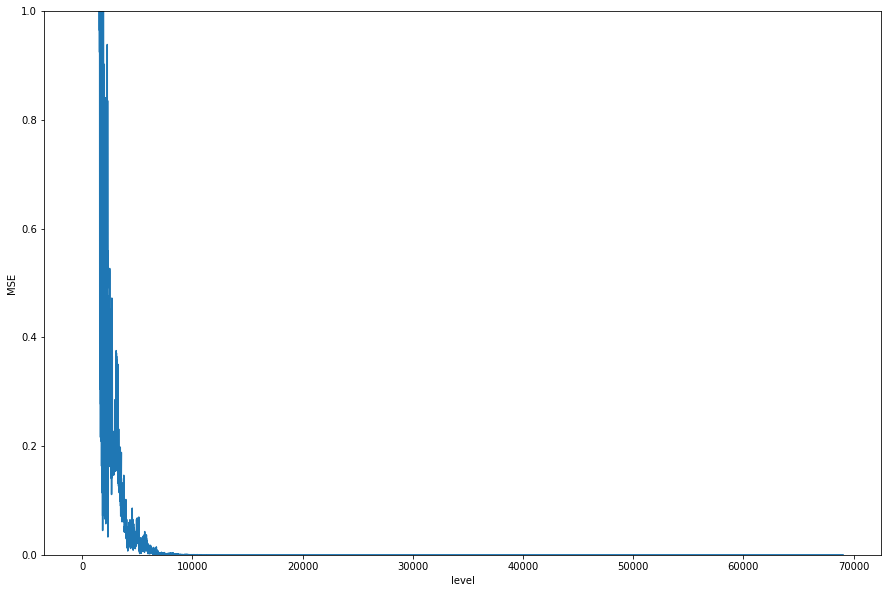

In [23]:
simulated_annealing.progress.plot(x='level', y='MSE', ylim=(0, 1))

<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        نمودار $log(T)$
        برحسب $level$
    </font>
</div>

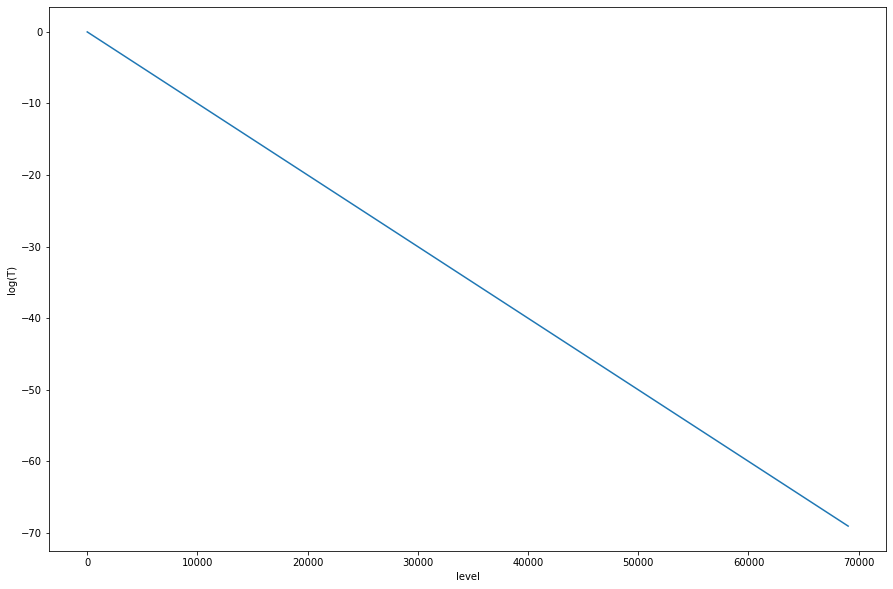

In [24]:
simulated_annealing.progress.plot(x='level', y='log(T)')

<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        نمودار $MSE$
        در بازه‌ی ۰ تا ۱
        برحسب $log(T)$
    </font>
</div>

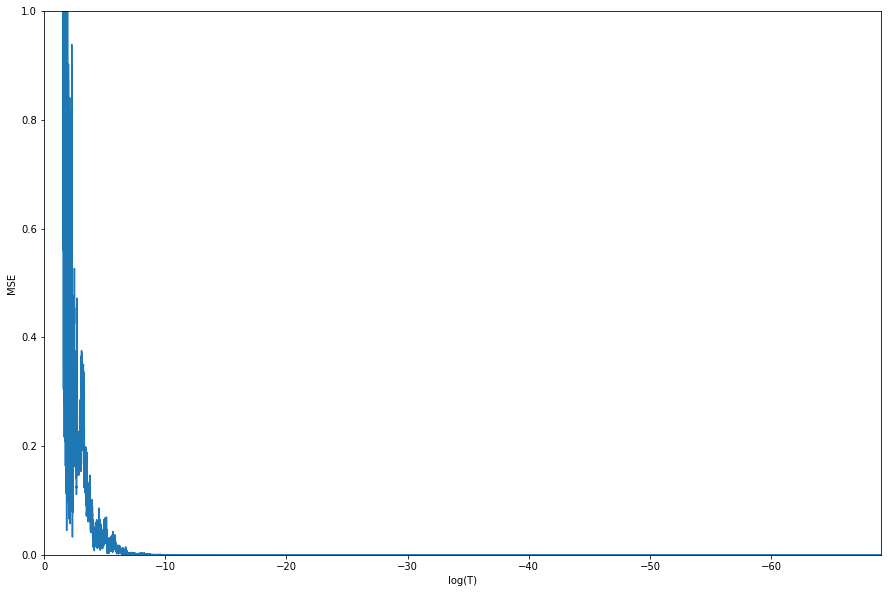

In [25]:
simulated_annealing.progress.plot(x='log(T)', y='MSE', invert=True, ylim=(0,1))

<div style="direction:rtl;line-height:300%;text-align:justify;">
	<font face="B Zar", size=5px>
        همانطور که مشاهده شد، نتایج حاصل از اجرای الگوریتم $Hill \space Climbing$
        دارای $MSE$
        از مرتبه‌ی $10^{-23}$
        هستند، درحالی‌که این نتایج برای الگوریتم $Simulated \space Annealing$
        از مرتبه‌ی $10^{-28}$
        هستند.
        <br>
        همچنین در الگوریتم $Hill \space Climbing$
        باید چند بار الگوریتم را اجرا کنیم تا بهینه ترین حالت ممکن بدست آید. در حالی که الگوریتم $Simulated \space Annealing$
        با یک بار اجرا، به دلیل حرکت‌های تصادفی، به بهترین حالت خود می‌رسد.
        <br>
        این نتایح دور ازانتظار نیز نبوده‌اند، چرا که الگوریتم $Simulated \space Annealing$
        به نوعی تکامل‌یافته‌ی الگوریتم $Hill \space Climbing$
        است و به علت عملکرد گاهاً تصادفی، همانطور که انیمیشن زیر مشخص می‌کند، می‌تواند از دام مینیمم های محلی بگریزد.
        <img src="SimulatedAnnealing.gif">
    </font>
</div>